By: Mohamed Ait Mhamed Belcaid, Graduate Student in Electrical Engineering, Michigan Technological University.


# References

Credit: codes developed in this project have been inspired by the following references:

\[1\] T. Havens, "Data Classification," CS/EE 5841 Machine Learning Lecture notes, College of Computing, Michigan Technological University, Spring 2020.

\[2\] https://gurus.pyimagesearch.com/lesson-sample-k-nearest-neighbor-classification/

\[3\] https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40

\[4\] https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays

\[5\] https://steven.codes/blog/ml/how-to-get-97-percent-on-MNIST-with-KNN/


# k-Nearest Neighbors Classification

## Description:

This project implements several kNN classifiers on the MNIST dataset. The MNIST training and testing dataset were donwloaded from http://yann.lecun.com/exdb/mnist/. Each image is 28x28 pixels.

KNeighborsClassifier() from the Scikit-Learn library is used to generate a model implementing the k-nearest neighbors classifier. To be explicit about how this function is used, its input/output arguments are described based on the documentation \[https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html\]:

Inputs: parameters to set up kNN algorithm, which have the following definition:

\- n_neighbors: k value of kNN; specifies the number of closest neighbors to look for.

\- weights    : default = 'uniform'; allows a weighted kNN version of the algorithm. The default value gives equal weight to the vote of each datapoint from the k neighboring points.

\- algorithm  : default = 'auto'; prompts the algorithm to determine the best approach among \['ball_tree', 'kd_tree', 'brute'\] based on the training data.

\- leaf_size  : default = 30; indicates the leaf size passed to BallTree or KDTree. 

\- metric     : default = 'minkowski'; indicates the distance metric to use for the tree. The default value with p=2 is equivalent to the Euclidean metric.

Output: class for kNN "model", which encompasses methods with the following definitions:

\- model.score(X,y): computes the mean accuracy (= 1 - error) on the given test data X and labels y (self.predict(X) wrt. y).

\- model.fit(X,y): fits the model using X as training data and y as target labels.

\- model.predict(X): predicts the class labels for the provided data, i.e. given unlabeled observations X, returns the predicted labels y.

## Implementation:

The main functions implemented for the kNN classifier are presented in the following codes.

In [1]:
# import packages
from __future__ import print_function
import time
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Read MNIST data and labels from .gz files
#
# train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
# train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
# t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
# t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)
#
def read_mnist(filename):
    # Based on reference [3]
    # function that reads MNIST's file format into numpy arrays
    with gzip.open(filename) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
#
# training/validation data
filename       = 'train-images-idx3-ubyte.gz'
trainvalData3D = read_mnist(filename)
# convert 3D ndarrays of data to 2D array by reshaping each datapoint 28x28 to 1x784
# for any 3D ndarray a (l, m, n), use: numpy.reshape(a, (l, m*n))
a              = np.copy(trainvalData3D);
trainvalData   = np.reshape(a, (a.shape[0],a.shape[1]*a.shape[2]))
#
# training/validation labels
filename       = 'train-labels-idx1-ubyte.gz'
trainvalLabels = read_mnist(filename)
#
# testing data
filename       = 't10k-images-idx3-ubyte.gz'
testData3D     = read_mnist(filename)
# convert 3D ndarrays of data to 2D array by reshaping each datapoint 28x28 to 1x784
# for any 3D ndarray a (l, m, n), use: numpy.reshape(a, (l, m*n))
a              = np.copy(testData3D);
testData       = np.reshape(a, (a.shape[0],a.shape[1]*a.shape[2]))
#
# testing labels
filename       = 't10k-labels-idx1-ubyte.gz'
testLabels     = read_mnist(filename)
#

In [3]:
def run_knn(trainvalData, trainvalLabels, testData, testLabels, kVals):
    #
    # MNIST data and labels are in input arguments, kVals contains possible values for k for kNN classifier
    # leave-one-out cross validation: using this technique needed 60,000 training/validation evaluations per value of k
    # which significantly increased the execution time; as recommended by Dr. Havens, the training set is instead
    # randomly sampled to estimate the best k:
    (trainData, valData, trainLabels, valLabels) = train_test_split(trainvalData, trainvalLabels, test_size=0.1,
                                                                    random_state=84)
    # list of errors for each value of k
    errors = []
    print("\nk-NN with leave-one-out approach to select best value for k among")
    print("k values = ", list(kVals), ":")
    print("| k      | leave-one-out error (%)")
    # loop over various values of k for kNN classifier
    for k in kVals:
        # train kNN classifier on training sets
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(trainData, trainLabels)
        # validate kNN model and update list of errors
        # note that score is an accuracy, which is (1 - error)
        # format errors in percentage (%) form
        score = model.score(valData, valLabels)
        error = 100 * (1.0 - score)
        print("| %d \t | %.2f%%" % (k, error))
        errors.append(error)
    # plot error vs k:
    # plot for 5 or more values of k
    if len(kVals) >= 5:
        plt.plot(kVals, errors)
        plt.xticks(kVals)
        plt.xlabel('k number of neighbors (in kNN)')
        plt.ylabel('leave-one-out error (in %)')
        plt.show()
    # best value of k corresponding to smallest error
    i           = int(np.argmin(errors))
    print("k = %d resulted in lowest error of %.2f%% (on validation data)" % (kVals[i],errors[i]))
    # re-train kNN classifier using best value of k
    model       = KNeighborsClassifier(n_neighbors=kVals[i])
    model.fit(trainData, trainLabels)
    # test kNN classifier
    predictions = model.predict(testData)
    # generate report on testing accuracies (equiv. testing errors) per class/label {0,1,...,9}
    report_dict = classification_report(testLabels, predictions, output_dict=True)
    # testing error per class/label {0,1,...,9}
    classes     = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    print("Evaluating testing error using best value of k (on testing data):")
    print("| Class  | Testing error (%)")
    for class_key in classes:
        error_test   = 100 * (1 - report_dict[class_key]["precision"])
        print("| %s \t | %.2f%%" % (class_key, error_test))
    #
    return report_dict
#


## Question 1:

A 1-nearest neighbor classifier is implemented as shown in the implementation section above, which flattens the 28x28 image pixels to 1x784 pixel vector.

The testing error for each class (digit) are presented in the following table. Note that the testing error remains within $1.7-5.3\%$ value when using a number of k-neighbors $k=1$, which indicates the high accuracy of this classifier.

Note that the query time is extremely high as the kNN classifier considers all 784 features in each datapoint.

In [4]:
kVals  = [1]
# query time: start
tic    = time.perf_counter()
report = run_knn(trainvalData, trainvalLabels, testData, testLabels, kVals)
# query time: end
toc    = time.perf_counter()
print(f"\nQuery time is {toc - tic:0.4f} seconds")


k-NN with leave-one-out approach to select best value for k among
k values =  [1] :
| k      | leave-one-out error (%)
| 1 	 | 2.52%
k = 1 resulted in lowest error of 2.52% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 2.41%
| 1 	 | 3.17%
| 2 	 | 1.68%
| 3 	 | 4.06%
| 4 	 | 2.99%
| 5 	 | 5.26%
| 6 	 | 1.97%
| 7 	 | 4.08%
| 8 	 | 1.62%
| 9 	 | 4.64%

Query time is 934.4809 seconds


## Question 2:

A standard kNN leave-one-out approach is implemented as shown in the implementation section above. Since extremely long execution time problems arose from using all 60,000 training data points for leave-one-out, the training set was randomly sampled to estimate the best value for k-neighbors.

k-neighbors values ranging from 1 to 20 are tested to select the best value for k, and the resulting leave-one-out error values are shown in the following table. The best value for k-neighbors is $k=k_{best}=3$, which resulted in the lowest leave-one-out error. The leave-one-out error vs. $k$ is plotted in the following figure to confirm that the best value for k-neighbors is $k=k_{best}=3$, and that the leave-one-out error 'essentially' increases as the value of $k$ is increased.

The testing error obtained for each class (digit) using the best value of k are shown in the following table. Note that the testing error remains within $1-4.4\%$ value when using a number of k-neighbors $k=k_{best}=3$, which indicates the high accuracy of this classifier.

Note that the query time is extremely high as the kNN classifier considers all 784 features in each datapoint.


k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 2.52%
| 2 	 | 2.87%
| 3 	 | 2.38%
| 4 	 | 2.58%
| 5 	 | 2.72%
| 6 	 | 2.68%
| 7 	 | 2.90%
| 8 	 | 2.85%
| 9 	 | 2.97%
| 10 	 | 2.93%
| 11 	 | 2.97%
| 12 	 | 3.23%
| 13 	 | 3.23%
| 14 	 | 3.37%
| 15 	 | 3.40%
| 16 	 | 3.55%
| 17 	 | 3.57%
| 18 	 | 3.80%
| 19 	 | 3.80%
| 20 	 | 3.88%


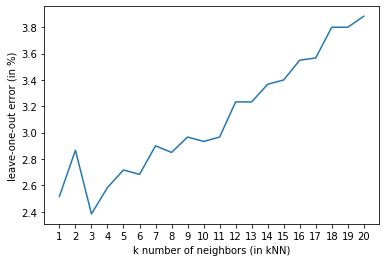

k = 3 resulted in lowest error of 2.38% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 3.47%
| 1 	 | 4.06%
| 2 	 | 1.87%
| 3 	 | 3.93%
| 4 	 | 2.67%
| 5 	 | 3.27%
| 6 	 | 1.46%
| 7 	 | 3.69%
| 8 	 | 0.98%
| 9 	 | 4.36%

Query time is 7667.7648 seconds


In [5]:
kVals  = range(1, 21, 1)
# query time: start
tic    = time.perf_counter()
report = run_knn(trainvalData, trainvalLabels, testData, testLabels, kVals)
# query time: end
toc    = time.perf_counter()
print(f"\nQuery time is {toc - tic:0.4f} seconds")

## Question 3:

A "$n^{th}$ pixel" sampler is implemented, which downsamples the image by sampling only every $n^{th}$ pixel (feature) in the 784-dimension datapoint.

The kNN leave-one-out experiment is repeated with at least 4 different values of $n = [4, 7, 14, 28]$.

k-neighbors values ranging from 1 to 20 are tested to select the best value for k, and the resulting leave-one-out error values are shown in the following tables. For all values of $n$ considered, the increased uncertainty due to the loss of pixel information by the "$n^{th}$ pixel" data sampler caused the leave-one-out error to increase to high levels. The declining uncertainty with higher values of $n$ also led to the best value for k-neighbors $k=k_{best}$ to increase with $n$, which means that the kNN classifier seeks the vote of more neighbors to identify each image. The leave-one-out error vs. $k$ is plotted in the following figures to confirm the high levels of leave-one-out error, and that the leave-one-out error significantly increases as the value of the sampling factor $n$ is increased.

For all values of $n$ considered, the testing error obtained for each class (digit) using the best value of k are shown in the following table. Even when using a number of k-neighbors $k=k_{best}$, the testing error significantly increases as the sampling factor $n$ increases, which indicates the degraded accuracy of this classifier with respect to increases in $n$.

Note that the query time for the kNN classifier with "$n^{th}$ pixel" sampler is much less than that of the standard kNN classifier, as the "$n^{th}$ pixel" sampler only considers $\lfloor 784/n \rfloor << 784$ features in each datapoint.

In [6]:
# sampler question 3: nth pixel selection
# n must be positive integer less than 784
#
def nth_idx_sampling(data, n):
    # samples down each datapoint in dataset 'data' by selecting each nth pixel
    n_data = data.shape[0]
    # sampling index: at each nth index
    samp_idx     = range(0,data.shape[1],n)
    # new datapoints will have length floor(784/n)
    newlen_data  = len(samp_idx)
    # initialize array
    data_sampled = np.empty([n_data,newlen_data])
    for i in range(0,n_data,1):
        # extract datapoint of length 784
        datapoint = data[i]
        # downsampling by factor n:
        # sample every nth pixel in datapoint
        data_sampled[i,:] = datapoint[samp_idx]
    return data_sampled
#

*****************************************************************
sampling factor n:  4
sampled train/val dataset shape:  (60000, 196)
sampled test dataset shape:  (10000, 196)

k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 7.18%
| 2 	 | 8.42%
| 3 	 | 6.93%
| 4 	 | 7.05%
| 5 	 | 7.22%
| 6 	 | 7.32%
| 7 	 | 7.28%
| 8 	 | 7.18%
| 9 	 | 7.32%
| 10 	 | 7.55%
| 11 	 | 7.40%
| 12 	 | 7.67%
| 13 	 | 7.70%
| 14 	 | 7.93%
| 15 	 | 7.98%
| 16 	 | 8.05%
| 17 	 | 8.02%
| 18 	 | 8.12%
| 19 	 | 8.07%
| 20 	 | 8.35%


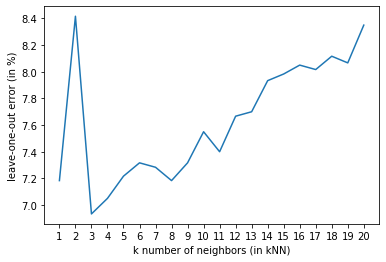

k = 3 resulted in lowest error of 6.93% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 5.41%
| 1 	 | 12.32%
| 2 	 | 4.10%
| 3 	 | 9.58%
| 4 	 | 7.64%
| 5 	 | 6.36%
| 6 	 | 3.83%
| 7 	 | 6.71%
| 8 	 | 4.10%
| 9 	 | 9.38%

Query time is 2014.2558 seconds
*****************************************************************
sampling factor n:  7
sampled train/val dataset shape:  (60000, 112)
sampled test dataset shape:  (10000, 112)

k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 17.33%
| 2 	 | 18.42%
| 3 	 | 15.27%
| 4 	 | 15.33%
| 5 	 | 14.83%
| 6 	 | 14.88%
| 7 	 | 14.65%
| 8 	 | 14.78%
| 9 	 | 14.80%
| 10 	 | 14.72%
| 11 	 | 14.67%
| 12 	 | 14.85%
| 13 	 | 15.07%
| 14 	 | 15.03%
| 15 	 | 14.97%
| 16 	 | 15.05%
| 17 	 | 15.32%
| 18 	 | 15.40%
| 19 	 | 15.50%
| 20 	 | 1

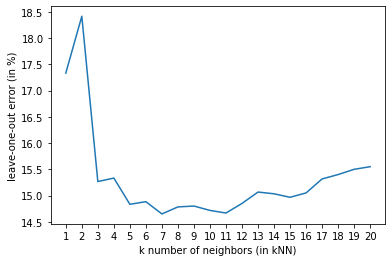

k = 7 resulted in lowest error of 14.65% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 10.49%
| 1 	 | 10.72%
| 2 	 | 9.01%
| 3 	 | 24.29%
| 4 	 | 12.18%
| 5 	 | 18.34%
| 6 	 | 15.23%
| 7 	 | 14.94%
| 8 	 | 23.94%
| 9 	 | 16.43%

Query time is 1272.7975 seconds
*****************************************************************
sampling factor n:  14
sampled train/val dataset shape:  (60000, 56)
sampled test dataset shape:  (10000, 56)

k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 32.55%
| 2 	 | 33.22%
| 3 	 | 29.52%
| 4 	 | 28.27%
| 5 	 | 27.33%
| 6 	 | 27.25%
| 7 	 | 26.80%
| 8 	 | 26.80%
| 9 	 | 26.53%
| 10 	 | 26.57%
| 11 	 | 26.35%
| 12 	 | 26.05%
| 13 	 | 26.20%
| 14 	 | 26.07%
| 15 	 | 25.95%
| 16 	 | 26.08%
| 17 	 | 25.82%
| 18 	 | 25.57%
| 19 	 | 25.87%
| 

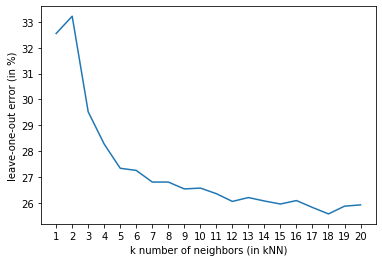

k = 18 resulted in lowest error of 25.57% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 17.90%
| 1 	 | 14.93%
| 2 	 | 29.00%
| 3 	 | 35.92%
| 4 	 | 17.35%
| 5 	 | 35.86%
| 6 	 | 27.70%
| 7 	 | 25.63%
| 8 	 | 33.37%
| 9 	 | 25.39%

Query time is 562.5429 seconds
*****************************************************************
sampling factor n:  28
sampled train/val dataset shape:  (60000, 28)
sampled test dataset shape:  (10000, 28)

k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 89.95%
| 2 	 | 90.08%
| 3 	 | 90.08%
| 4 	 | 88.78%
| 5 	 | 88.78%
| 6 	 | 90.08%
| 7 	 | 90.08%
| 8 	 | 90.08%
| 9 	 | 89.95%
| 10 	 | 90.08%
| 11 	 | 90.08%
| 12 	 | 90.08%
| 13 	 | 90.08%
| 14 	 | 90.08%
| 15 	 | 90.08%
| 16 	 | 90.08%
| 17 	 | 90.08%
| 18 	 | 88.78%
| 19 	 | 90.08%
|

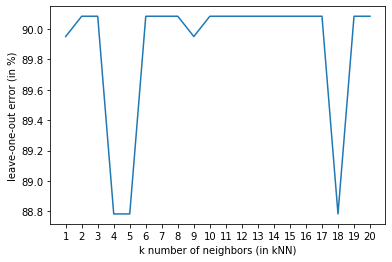

k = 4 resulted in lowest error of 88.78% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 100.00%
| 1 	 | 88.65%
| 2 	 | 100.00%
| 3 	 | 100.00%
| 4 	 | 100.00%
| 5 	 | 100.00%
| 6 	 | 100.00%
| 7 	 | 0.00%
| 8 	 | 100.00%
| 9 	 | 100.00%

Query time is 341.3799 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
# n must be positive integer less than 784
nvals  = [4, 7, 14, 28]
for n in nvals:
    trainvalData_samp_q3 = nth_idx_sampling(trainvalData, n)
    testData_samp_q3     = nth_idx_sampling(testData, n)
    # now that data is sampled, run kNN algorithm (replace data in upcoming arguments by data_samp_q3)
    #
    print("*****************************************************************")
    print("sampling factor n: ", n)
    print("sampled train/val dataset shape: ",trainvalData_samp_q3.shape)
    print("sampled test dataset shape: ",testData_samp_q3.shape)
    #
    kVals  = range(1, 21, 1)
    # query time: start
    tic    = time.perf_counter()
    report = run_knn(trainvalData_samp_q3, trainvalLabels, testData_samp_q3, testLabels, kVals)
    # query time: end
    toc    = time.perf_counter()
    print(f"\nQuery time is {toc - tic:0.4f} seconds")
#

## Question 4:

A "$n \times n$ block" function that downsamples the datapoint by binning nearby pixels in a single block is implemented; the 28x28 pixels image is binned down to blocks of $n \times n$ pixels for which the pixels are then summed up.

The kNN leave-one-out experiment is repeated with at least 4 different values of $n = [4, 7, 14, 28]$.

k-neighbors values ranging from 1 to 20 are tested to select the best value for k, and the resulting leave-one-out error values are shown in the following tables. For all values of $n$ considered, the increased uncertainty due to the loss of pixel information by summing up pixel in the "$n \times n$ block" data sampler caused the leave-one-out error to increase to high levels. The declining uncertainty with higher values of $n$ also led to the best value for k-neighbors $k=k_{best}$ to increase with $n$, which means that the kNN classifier seeks the vote of more neighbors to identify each image. The leave-one-out error vs. $k$ is plotted in the following figures to confirm the high levels of leave-one-out error, and that the leave-one-out error significantly increases as the value of the sampling factor $n$ is increased.

For all values of $n$ considered, the testing error obtained for each class (digit) using the best value of k are shown in the following table. Even when using a number of k-neighbors $k=k_{best}$, the testing error significantly increases as the sampling factor $n$ increases, which indicates the degraded accuracy of this classifier with respect to increases in $n$.

Note that the query time for the kNN classifier with "$n \times n$ block" sampler is much less than that of the standard kNN classifier, as the "$n \times n$ pixel" sampler only considers $\lceil 784/n^2 \rceil << 784$ features in each datapoint.

In [4]:
# sampler question 4 & 5: sum pixels in every block of n*n size
#
def blockshaped(arr, nrows, ncols):
    # Based on reference [4]
    # Return array of shape (n, nrows, ncols) where n * nrows * ncols = arr.size
    # If arr is a 2D array, returned array is n sub-blocks with, each preserving "physical" layout of arr
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisible by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisible by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))
#
# note n should be a divider of 28
def blocks_sampling(data, n):
    # samples down each datapoint to blocks of nxn size, then sums the pixels in each block
    n_data          = data.shape[0]
    # new datapoints will have length ceil(28^2/n^2)
    newlen_data     = np.ceil(data.shape[1]/(n*n)).astype('int')
    # initialize array
    data_sampled    = np.empty([n_data,newlen_data])
    for i in range(0,n_data,1):
        # extract datapoint of length 784
        mydatapoint = data[i]
        # downsamples 784x1 = 28x28 datapoint to blocks of nxn size, then sums the pixels in each block
        # reshape 1-D datapoint to size 28x28:
        datapoint   = np.array(mydatapoint).reshape((28,28))
        # slice datapoint into blocks of size nxn:
        blocks      = blockshaped(datapoint, n, n)
        # initialize array
        newdatapoint      = np.empty(blocks.shape[0])
        # sum pixels in each block
        for k in range(0,blocks.shape[0],1):
            newdatapoint[k] = np.sum(blocks[k])
        # store
        data_sampled[i,:] = newdatapoint
    #
    return data_sampled
#

*****************************************************************
sampling factor n:  4
sampled train/val dataset shape:  (60000, 49)
sampled test dataset shape:  (10000, 49)

k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 4.72%
| 2 	 | 5.03%
| 3 	 | 4.12%
| 4 	 | 4.43%
| 5 	 | 4.40%
| 6 	 | 4.55%
| 7 	 | 4.43%
| 8 	 | 4.60%
| 9 	 | 4.68%
| 10 	 | 4.80%
| 11 	 | 4.80%
| 12 	 | 4.90%
| 13 	 | 5.02%
| 14 	 | 5.07%
| 15 	 | 5.12%
| 16 	 | 5.17%
| 17 	 | 5.35%
| 18 	 | 5.37%
| 19 	 | 5.45%
| 20 	 | 5.55%


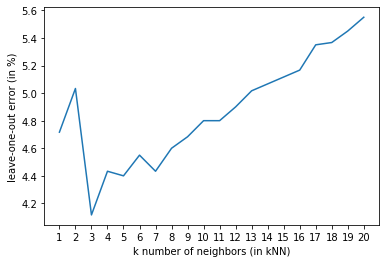

k = 3 resulted in lowest error of 4.12% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 3.38%
| 1 	 | 3.34%
| 2 	 | 2.37%
| 3 	 | 5.48%
| 4 	 | 4.79%
| 5 	 | 5.08%
| 6 	 | 4.00%
| 7 	 | 5.18%
| 8 	 | 5.89%
| 9 	 | 9.31%

Query time is 306.1317 seconds
*****************************************************************
sampling factor n:  7
sampled train/val dataset shape:  (60000, 16)
sampled test dataset shape:  (10000, 16)

k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 20.72%
| 2 	 | 21.55%
| 3 	 | 18.62%
| 4 	 | 18.00%
| 5 	 | 17.48%
| 6 	 | 17.47%
| 7 	 | 17.02%
| 8 	 | 17.30%
| 9 	 | 17.27%
| 10 	 | 17.47%
| 11 	 | 17.48%
| 12 	 | 17.73%
| 13 	 | 17.47%
| 14 	 | 17.42%
| 15 	 | 17.75%
| 16 	 | 17.67%
| 17 	 | 17.73%
| 18 	 | 17.78%
| 19 	 | 17.85%
| 20 	 | 17.83

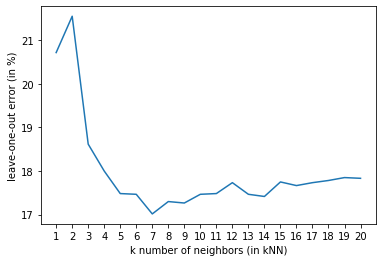

k = 7 resulted in lowest error of 17.02% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 22.06%
| 1 	 | 9.65%
| 2 	 | 9.06%
| 3 	 | 14.06%
| 4 	 | 21.73%
| 5 	 | 16.63%
| 6 	 | 9.20%
| 7 	 | 14.73%
| 8 	 | 29.54%
| 9 	 | 30.08%

Query time is 31.1658 seconds
*****************************************************************
sampling factor n:  14
sampled train/val dataset shape:  (60000, 4)
sampled test dataset shape:  (10000, 4)

k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 59.10%
| 2 	 | 58.12%
| 3 	 | 55.50%
| 4 	 | 54.38%
| 5 	 | 53.23%
| 6 	 | 52.17%
| 7 	 | 51.93%
| 8 	 | 51.30%
| 9 	 | 51.33%
| 10 	 | 51.15%
| 11 	 | 50.48%
| 12 	 | 50.55%
| 13 	 | 50.20%
| 14 	 | 49.93%
| 15 	 | 49.30%
| 16 	 | 49.33%
| 17 	 | 49.08%
| 18 	 | 49.00%
| 19 	 | 48.90%
| 20 	 |

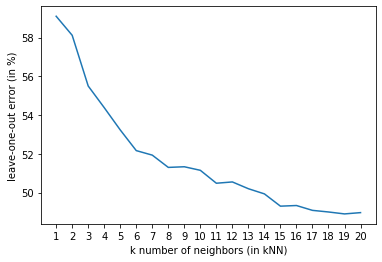

k = 19 resulted in lowest error of 48.90% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 55.10%
| 1 	 | 17.20%
| 2 	 | 46.25%
| 3 	 | 60.97%
| 4 	 | 55.94%
| 5 	 | 62.85%
| 6 	 | 40.94%
| 7 	 | 40.39%
| 8 	 | 67.18%
| 9 	 | 62.27%

Query time is 4.9774 seconds
*****************************************************************
sampling factor n:  28
sampled train/val dataset shape:  (60000, 1)
sampled test dataset shape:  (10000, 1)

k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 82.97%
| 2 	 | 81.03%
| 3 	 | 80.77%
| 4 	 | 80.53%
| 5 	 | 80.48%
| 6 	 | 80.43%
| 7 	 | 80.18%
| 8 	 | 79.93%
| 9 	 | 79.87%
| 10 	 | 79.93%
| 11 	 | 79.77%
| 12 	 | 79.92%
| 13 	 | 79.70%
| 14 	 | 79.45%
| 15 	 | 79.30%
| 16 	 | 79.25%
| 17 	 | 78.95%
| 18 	 | 78.88%
| 19 	 | 79.02%
| 20 

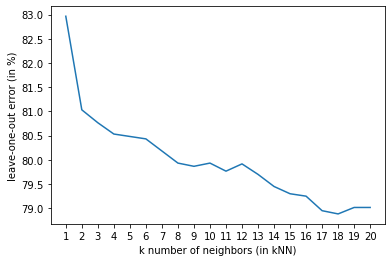

k = 18 resulted in lowest error of 78.88% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 76.88%
| 1 	 | 50.38%
| 2 	 | 84.90%
| 3 	 | 89.13%
| 4 	 | 86.84%
| 5 	 | 88.72%
| 6 	 | 90.94%
| 7 	 | 83.91%
| 8 	 | 87.58%
| 9 	 | 83.84%

Query time is 4.2352 seconds


In [5]:
# note n should be a divider of 28
nvals  = [4, 7, 14, 28]
for n in nvals:
    trainvalData_samp_q4_q5 = blocks_sampling(trainvalData, n)
    testData_samp_q4_q5     = blocks_sampling(testData, n)
    # now that data is sampled, run kNN algorithm (replace data in upcoming arguments by data_samp_q4_q5)
    #
    print("*****************************************************************")
    print("sampling factor n: ", n)
    print("sampled train/val dataset shape: ",trainvalData_samp_q4_q5.shape)
    print("sampled test dataset shape: ",testData_samp_q4_q5.shape)
    #
    kVals  = range(1, 21, 1)
    # query time: start
    tic    = time.perf_counter()
    report = run_knn(trainvalData_samp_q4_q5, trainvalLabels, testData_samp_q4_q5, testLabels, kVals)
    # query time: end
    toc    = time.perf_counter()
    print(f"\nQuery time is {toc - tic:0.4f} seconds")
#

## Question 5:

The "$n \times n$ block" downsampler is run at n = 28, which reduces each datapoint down to 1 pixel by summing up its features.

The kNN leave-one-out experiment is repeated with a value of $n=28$.

k-neighbors values ranging from 1 to 20 are tested to select the best value for k, and the resulting leave-one-out error values are shown in the following tables. For the value of $n=28$ considered, the increased uncertainty due to the loss of pixel information by summing up pixel in the "$n \times n$ block" data sampler caused the leave-one-out error to increase to high levels. The declining uncertainty with this high value of $n=28$ also led to the best value for k-neighbors $k=k_{best}$ to increase, which means that the kNN classifier seeks the vote of more neighbors to identify each image. The leave-one-out error vs. $k$ is plotted in the following figures to confirm the high levels of leave-one-out error, and that the leave-one-out error significantly increases for this high value of the sampling factor $n=28$.

For the value of $n=28$ considered, the testing error obtained for each class (digit) using the best value of k are shown in the following table. Even when using a number of k-neighbors $k=k_{best}$, the testing error significantly increases for the high value of sampling factor $n=28$, which indicates the degraded accuracy of this classifier for this high value of the sampling factor $n=28$.

Note that the query time for the kNN classifier with "$n \times n$ block" sampler is much less than that of the standard kNN classifier, as the "$n \times n$ pixel" sampler for $n=28$ only considers $1 << 784$ feature in each datapoint.

*****************************************************************
sampling factor n:  28
sampled train/val dataset shape:  (60000, 1)
sampled test dataset shape:  (10000, 1)

k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 82.97%
| 2 	 | 81.03%
| 3 	 | 80.77%
| 4 	 | 80.53%
| 5 	 | 80.48%
| 6 	 | 80.43%
| 7 	 | 80.18%
| 8 	 | 79.93%
| 9 	 | 79.87%
| 10 	 | 79.93%
| 11 	 | 79.77%
| 12 	 | 79.92%
| 13 	 | 79.70%
| 14 	 | 79.45%
| 15 	 | 79.30%
| 16 	 | 79.25%
| 17 	 | 78.95%
| 18 	 | 78.88%
| 19 	 | 79.02%
| 20 	 | 79.02%


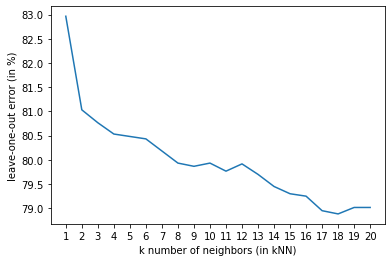

k = 18 resulted in lowest error of 78.88% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 76.88%
| 1 	 | 50.38%
| 2 	 | 84.90%
| 3 	 | 89.13%
| 4 	 | 86.84%
| 5 	 | 88.72%
| 6 	 | 90.94%
| 7 	 | 83.91%
| 8 	 | 87.58%
| 9 	 | 83.84%

Query time is 4.0707 seconds


In [6]:
# note n should be a divider of 28
nvals  = [28]
for n in nvals:
    trainvalData_samp_q4_q5 = blocks_sampling(trainvalData, n)
    testData_samp_q4_q5     = blocks_sampling(testData, n)
    # now that data is sampled, run kNN algorithm (replace data in upcoming arguments by data_samp_q4_q5)
    #
    print("*****************************************************************")
    print("sampling factor n: ", n)
    print("sampled train/val dataset shape: ",trainvalData_samp_q4_q5.shape)
    print("sampled test dataset shape: ",testData_samp_q4_q5.shape)
    #
    kVals  = range(1, 21, 1)
    # query time: start
    tic    = time.perf_counter()
    report = run_knn(trainvalData_samp_q4_q5, trainvalLabels, testData_samp_q4_q5, testLabels, kVals)
    # query time: end
    toc    = time.perf_counter()
    print(f"\nQuery time is {toc - tic:0.4f} seconds")
#

## Question 6:

A feature transformation method proposed in \[5\], based on principal component analysis (PCA), is implemented and then used in the kNN leave-one-out experiment. Author in  \[5\] has presented a feature transformation that significantly reduces the query time while slightly improving the testing error. The standard kNN considers all 784 dimensions for each datapoint to compute the distances, which significantly slows down the algorithm, especially that kNN is not recommended for more the 20 dimensions where distances become approximately equal. A significant number of features in each datapoint contain only 0 values (empty pixels) which shouldn't affect the algorithms predictions depending on their location. Additionnally, using all 784 features could prompt kNN to overfit the training data when considering feature anomalies don't generalize well. Author in \[5\] proposed to use Principal Component Analysis to remove features that do not contribute much to the predictions; this is essentially achieved by simples linear combinations of the original features. The new data will be projected into a new coordinate system with less dimensions, where only the "strongest" axes directions are considered, where the training data has higher variance. First, each feature in the dataset matrix is centered around 0 by subtracting the mean for each dimension to construct the design matrix $X$: $X_j=data_j-\mu_j$. Using Singular Value Decomposition (SVD), design matrix $X$ is decomposed into $X=UDV^T$, and the principal components are given by $XV=UD$. Thus, the $K_{PCA}$ principal components are obtained by taking only the first $K_{PCA}$ columns of $U$ and the first $K_{PCA}$ entries of $D$. The author in \[5\] shows that choosing a value $K_{PCA}\approx{40,50}$ results in a new dataset of that dimensionality which significantly reduces the query time compared to the original dataset. Note that PCA transformation should be applied to the entire dataset by concatenating the training and testing datasets.

The kNN leave-one-out experiment is repeated with "PCA" data sampler.

k-neighbors values ranging from 1 to 20 are tested to select the best value for k, and the resulting leave-one-out error values are shown in the following table. The best value for k-neighbors is $k=k_{best}=1$, which resulted in the lowest leave-one-out error. This means that the kNN classifier seeks the vote of only the one closest neighbor to identify each image, and indicates a high level of certainty in the model. The leave-one-out error vs. $k$ is plotted in the following figures to confirm that the best value for k-neighbors is $k=k_{best}=1$, and that the leave-one-out error 'essentially' increases as the value of $k$ is increased.

The testing error obtained for each class (digit) using the best value of k are shown in the following table. When using a number of k-neighbors $k=k_{best}=1$, note that the testing error is slightly improved compared to the standard kNN, which indicates the very high accuracy of this classifier which 'ignores' the 'weakest' axes (with lowest variance) of the data.

Note that the query time for the kNN classifier with "$n \times n$ block" sampler is significantly less than that of the standard kNN classifier, as the "PCA" sampler only considers $K_{PCA} = 50 << 784$ features in each datapoint.

In [7]:
# feature transformation question 6: Principal Component Analysis
# PCA: "compress" data to only its k principal components
def svd_pca(data, k):
    # Based on reference [5]
    # Reduce DATA using its K principal components
    data    = data.astype("float64")
    data   -= np.mean(data, axis=0)
    U, S, V = np.linalg.svd(data, full_matrices=False)
    return U[:,:k].dot(np.diag(S)[:k,:k])
#


k-NN with leave-one-out approach to select best value for k among
k values =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] :
| k      | leave-one-out error (%)
| 1 	 | 1.95%
| 2 	 | 2.23%
| 3 	 | 2.07%
| 4 	 | 2.02%
| 5 	 | 2.03%
| 6 	 | 2.18%
| 7 	 | 2.27%
| 8 	 | 2.32%
| 9 	 | 2.47%
| 10 	 | 2.45%
| 11 	 | 2.63%
| 12 	 | 2.57%
| 13 	 | 2.87%
| 14 	 | 2.90%
| 15 	 | 2.98%
| 16 	 | 2.95%
| 17 	 | 3.07%
| 18 	 | 3.12%
| 19 	 | 3.10%
| 20 	 | 3.10%


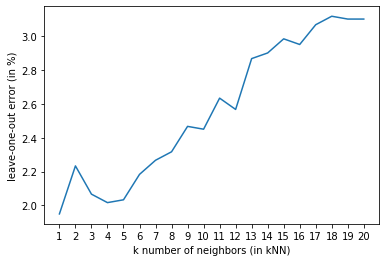

k = 1 resulted in lowest error of 1.95% (on validation data)
Evaluating testing error using best value of k (on testing data):
| Class  | Testing error (%)
| 0 	 | 1.82%
| 1 	 | 1.83%
| 2 	 | 2.32%
| 3 	 | 3.21%
| 4 	 | 2.87%
| 5 	 | 3.88%
| 6 	 | 1.87%
| 7 	 | 2.93%
| 8 	 | 2.50%
| 9 	 | 3.89%

Query time is 426.8182 seconds


In [8]:
# set K number of principal components
K_PCA  = 50
# concatenate data row under row (axis=0)
a      = np.concatenate((trainvalData, testData), axis=0)
# apply PCA
data   = svd_pca(a, K_PCA)
# split concatenated output
trainvalData_pca_q6 = data[0:60000]
testData_pca_q6     = data[60000:70000]
# run kNN
kVals  = range(1, 21, 1)
# query time: start
tic    = time.perf_counter()
report = run_knn(trainvalData_pca_q6, trainvalLabels, testData_pca_q6, testLabels, kVals)
# query time: end
toc    = time.perf_counter()
print(f"\nQuery time is {toc - tic:0.4f} seconds")
#